# In-vacuo TPA

- Calculations relevant for experiment proposal in collaboration with Alex Fontana, January 2022

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 18

In [3]:
from IPython.display import Image
from IPython.display import Math
from IPython.display import Latex

In [4]:
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Tue Nov  2 12:12:25 2021


In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tables            as tb
import random
import glob
import warnings
#sns.set()
from jupyterthemes import jtplot

In [6]:
jtplot.style('grade3')
from  invisible_cities.core.system_of_units import *

In [7]:
from sabat.sbt_types import FoV, CircularFoV, Monolayer
from sabat.sbt_types import Laser, PulsedLaser, GLaser, GaussianBeam
from sabat.sbt_types import Molecule
from sabat.sbt_types import Molecule2P
from sabat.sbt_types import DyeSample
from sabat.sbt_types import Microscope
from sabat.sbt_types import CCD
from sabat.sbt_types import PhotonsPerSample

In [8]:
from sabat.sbt_core import  power_density
from sabat.sbt_core import  photon_density
from sabat.sbt_core import  fluorescence_per_molecule
from sabat.sbt_core import  duration_of_fluorescence
from sabat.sbt_core import  diffraction_limit
from sabat.sbt_core import  photoelectrons_per_pixel
from sabat.sbt_core import  absorbed_photons_per_fluorophore_per_pulse_2p
from sabat.sbt_core import  fluorescence_2p_gb
from sabat.sbt_core import  fluorescence_2p_dl
from sabat.sbt_core import  fluorescence_dl_2p
from sabat.sbt_core import  fluorescence_dl
from sabat.sbt_core import  photon_per_sample
from sabat.sbt_core import  signal

In [9]:
from sabat.sbt_types import  photon, molecule, GM, us, ucm2, ucm3, gp 

In [10]:
from sabat.sbt_core  import  FLUO3
from sabat.sbt_core import  Setup

In [10]:
from sabat.FIB  import  FIB 

ModuleNotFoundError: No module named 'sabat.FIB'

In [11]:
def obective_transmission(NA):
    return (1 -np.cos(NA))/2

In [12]:
obective_transmission(0.6)

0.08733219254516084

In [13]:
def set_fonts(ax, fontsize=20):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)


# σ$_{TPA}$ is estimated by scaling Fluorescein spectrum

### Scale up FBI absorption spectrum

In [14]:
from   dataclasses import dataclass
@dataclass
class FBI:
    GM = 17.2 * 1e-50 * cm2*cm2*second
    lamda : np.array = np.array([691 * nm,
                        700 * nm ,
                        720 * nm ,
                        740 * nm ,
                        760 * nm ,
                        780 * nm ,
                        800 * nm ,
                        820 * nm ,
                        840 * nm ,
                        860 * nm ,
                        890 * nm ,
                        900 * nm ,
                        920 * nm ,
                        940 * nm ,
                        960 * nm ,
                        980 * nm ,
                        1000* nm ])
    s2 :    np.array  = np.array([16 * GM,
                         19 * GM,
                         19 * GM,
                         30 * GM,
                         36 * GM,
                         36 * GM,
                         36 * GM,
                         29 * GM,
                         13 * GM,
                         8  * GM,
                         11 * GM,
                         16 * GM,
                         26 * GM,
                         11 * GM,
                         15 * GM,
                         10 * GM,
                         5  * GM])

    def sigma2(self, lamda : float)->float:
        return np.interp(lamda, self.lamda, self.s2)



In [42]:
fbi = FBI()
sigmaFBI800 = fbi.sigma2(800*nm)
sigmaFBI800/GM

619.2

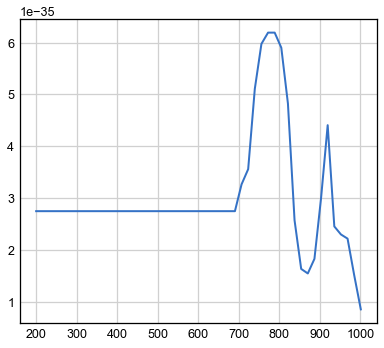

In [15]:
lamda = np.linspace(200, 1001)
sigmas = [FBI().sigma2(l*nm) for l in lamda]
plt.plot(lamda, sigmas)

In [18]:
path_absorption = '/Users/pabloherrero/sabat/LabFBIp/data/fluorimeter/FBI/absorption_FBI_FBI-Ba_exc200nm_5e-5M.csv'
df = pd.read_csv(path_absorption, sep=';', skiprows=2, index_col=1, header=None, decimal=',')
df.drop(0, axis=1, inplace=True)
for i in range(7,15):
    df.drop(i, axis=1, inplace=True)

df.columns = ['FBI-Ba-AcN', 'FBI-AcN', 'AcN', 'FBI-Ba', 'FBI']

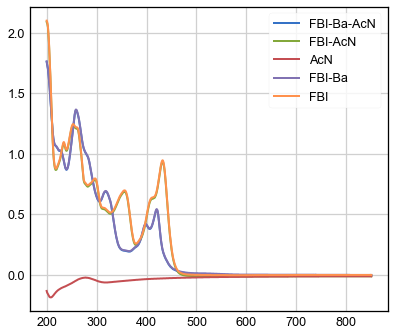

In [21]:
for c in df:
    plt.plot(df[c], label=c)
plt.legend()

In [50]:
np.argmax(df['FBI-Ba'].loc[250:])
normtpa = sigmaFBI800 / df['FBI-Ba'].loc[400]  # Scale factor 
normtpa

1.4884615384615386e-34

In [59]:
sigma_tpa = df * normtpa

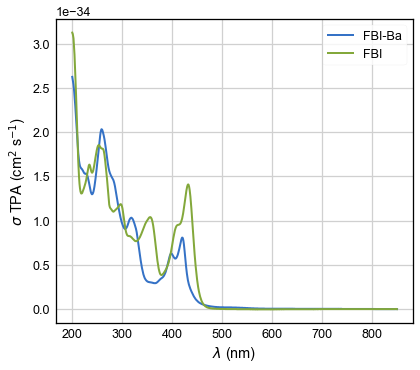

In [53]:
plt.plot(df['FBI-Ba']*normtpa)
plt.plot(df['FBI']*normtpa, label='FBI')

plt.ylabel('$\\sigma$ TPA (cm$^2$ s$^{-1}$)')
plt.xlabel('$\\lambda$ (nm)')
plt.legend()

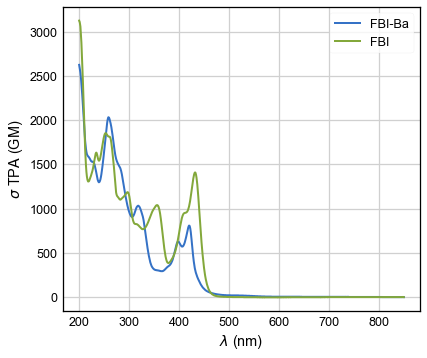

In [138]:
plt.plot(df['FBI-Ba']*normtpa/GM)
plt.plot(df['FBI']*normtpa/GM)
plt.ylabel('$\\sigma$ TPA (GM)')
plt.xlabel('$\\lambda$ (nm)')
plt.legend()


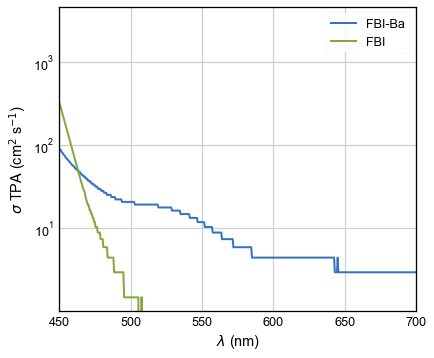

In [137]:
plt.plot(df['FBI-Ba']*normtpa/GM)
plt.plot(df['FBI']*normtpa/GM, label='FBI')

plt.ylabel('$\\sigma$ TPA (cm$^2$ s$^{-1}$)')
plt.xlabel('$\\lambda$ (nm)')
plt.xlim(450, 700)
plt.yscale('log')
plt.legend()


In [68]:

sigmaFBI = sigma_tpa['FBI'].loc[650/2]
sigmaFBIBa = sigma_tpa['FBI-Ba'].loc[650/2]

sigmaFBI / GM, sigmaFBIBa / GM

(772.5115384615385, 957.0807692307693)

### Quantum yield for FBI

In [76]:
qFBI = 0.25

## Laser is CW tunable from 450 to 600, max P ≈ 100 mW 

In [80]:
lb650 = Laser(lamda=650*nm, power=2e+2*mW,)  
lb650


        Laser:
        wavelength                =6.5e+02 nm
        photon energy             =1.9e+00 eV
        power                     =2.0e+02 mW
        energy per second         =2.0e+02 mJ
        photons per second        =6.5e+17 ph/second
        

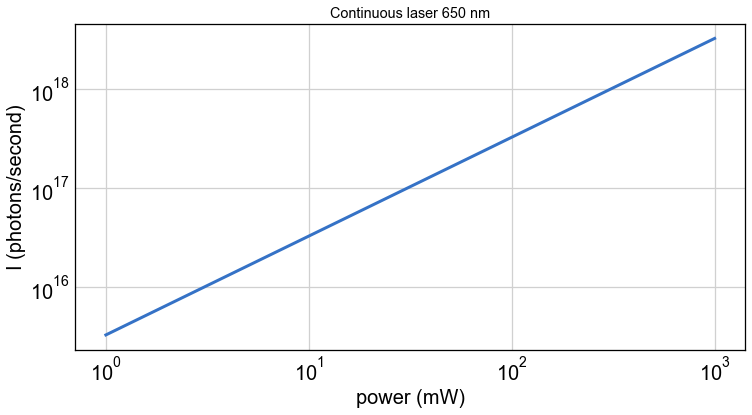

In [30]:
P  = np.linspace(1,1001) 
LB2 =[Laser(lamda=650*nm, power=p*mW,)   for p in P ]
FF2 =np.array([lb.n_photons() for lb in LB2])

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.loglog(P, FF2/us, linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("I (photons/second)")
plt.title('Continuous laser 650 nm')
plt.grid(True)

### Microscope

In [82]:
mc = Microscope(name='True', numerical_aperture=0.6, magnification=100,  
                eff_PMT = 1, eff_dichroic = 0.95, eff_filter = 0.99) 
print(mc)


        name                 = True
        NA                   = 6.0e-01
        M                    = 1.0e+02
        eff dichroic         = 9.50e-01
        eff filter           = 9.90e-01
        eff PMT              = 1.00e+00
        Optical transmission = 8.73e-02
        Filter  transmission = 9.41e-01
        Total transmission   = 7.72e-02
        


In [84]:
dl = diffraction_limit(lb650, mc)
fov = CircularFoV(dl, z=2*dl).area()/cm2

print('%.2e W/cm2' %(lb650.power / W /fov ))

5.83e+07 W/cm2


In [85]:
def system_photon_density(laser, microscope):
    dl  = diffraction_limit(laser, microscope)
    fov = CircularFoV(d = dl, z= 2 * dl)
    return dl, fov, photon_density(laser, fov)

In [88]:
dl650, f650, i650 = system_photon_density(lb650, mc)
print(f' diffraction limit for 650 nm mc = {dl650/micron}')
print(f' photon density = {i650/(us*ucm2):5.1e} photons/(second cm2)')

 diffraction limit for 650 nm mc = 0.6608333333333335
 photon density = 1.9e+26 photons/(second cm2)


In [89]:
ns = 1.0E2 * 1.0E2 / (0.5 * 0.5)
print(f'ns = {ns:.2e}')

ns = 4.00e+04


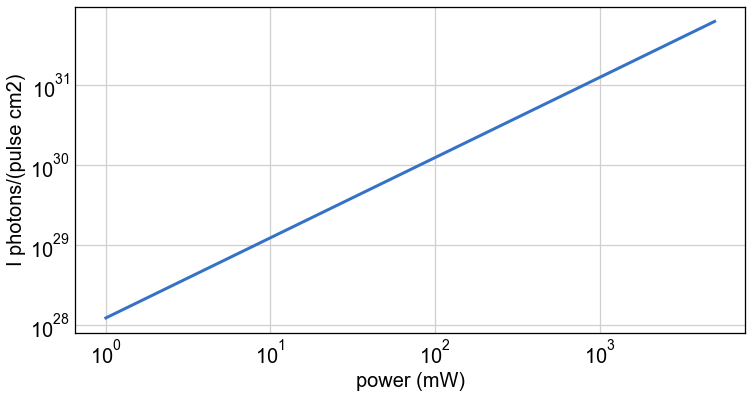

In [96]:
P  = np.linspace(1,5001) 
LB2 =[PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
II =np.array([photon_density(lb, f500) for lb in LB2])

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.loglog(P, II/lb500.tau/(us*ucm2), linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("I photons/(pulse cm2)")
plt.grid(True)

## Number of absorbed photons in CW laser

In [110]:
def absorbed_photons_per_fluorophore_cw_2p(lb: GLaser, mc : Microscope)->float:
    """
        na = (p0^2 * delta) * (A^2/(2 hbarc * lambda))^2
        natural units, hbarc = 1
    """

    hbarc   = 3.16    * 1e-24                    # J cm
    p0      = lb.power/W                         # W (J/S)
    delta   = sigmaFBI/(cm2*cm2*s)     # cm4 s
    lamda   = lb.lamda/cm                       # cm
    A       = mc.numerical_aperture

    t1 = (p0**2 * qFBI * delta)
    t2 = (A**2 / (2 * hbarc * lamda))**2
    return t1 * t2 

def absorbed_photons_per_fluorophore_cw_2p_wf(lb: GLaser, mc : Microscope, wr : float)->float:
    """
        na = (p0^2 * delta)/(tau * f^2) * (A^2/(2 hbarc * lambda))^2
        natural units, hbarc = 1
        
        wr: radius of wide field
        Note: this does not take into account the rapid fall of the gaussian profile out of focus

    """
    na = absorbed_photons_per_fluorophore_cw_2p(lb, mc)
    rd = diffraction_limit(lb, mc)
    #print(f' diffraction limit for laser = {rd/micron}')
    f = (wr / rd)**2
    #print(f' cost factor for WF = {f:5.2e}')
    return na /f

In [105]:
na = absorbed_photons_per_fluorophore_cw_2p(lb650, mc)
na

59326.55176389825

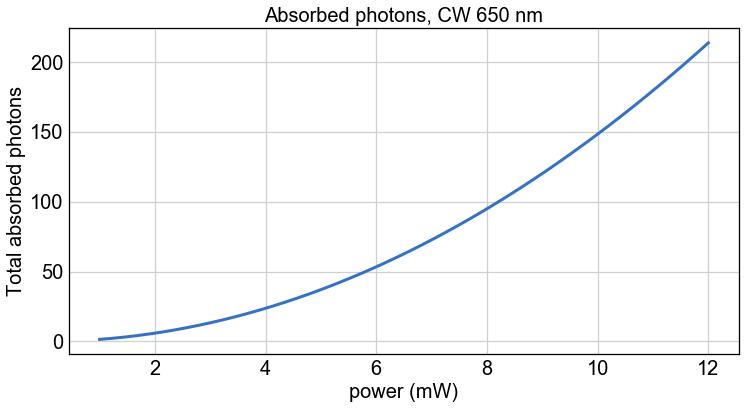

In [107]:
P  = np.linspace(1,12) 
LB2 = [Laser(lamda=650*nm, power=p*mW) for p in P ]
NA  = [absorbed_photons_per_fluorophore_cw_2p(lb, mc) for lb in LB2]

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.plot(P, NA, linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("Total absorbed photons")
plt.title("Absorbed photons, CW 650 nm", fontsize=20)
plt.grid(True)

### In wide field

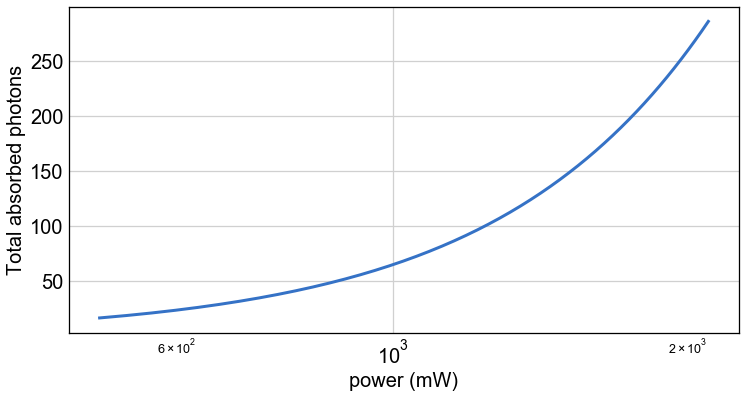

In [109]:
P  = np.linspace(501,2101) 
LB2 = [Laser(lamda=650*nm, power=p*mW) for p in P ]
NA  = [absorbed_photons_per_fluorophore_cw_2p_wf(lb, mc, wr=100*micron) for lb in LB2]

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.semilogx(P, NA, linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("Total absorbed photons")
plt.grid(True)

# Monolayer

## Total emitted photons
$$ N_{em} = N_{abs} Q f_{cov} \rho_s \pi r_{fov}  $$
- $N_{abs}$ is the number of absorbed photons per fluorophore
- Q is the quantum yield of the fluorophore (estimated 0.25)
- $f_{cov}$ is the coverage in ML
- $\rho_s$ = 1 nm$^{-2}$ is the surface density of molecules 
- $r_{fov}$ is the radius of the Field of View


In [120]:
1/nm**2

999999999999.9996

In [114]:
dl / micron

0.6608333333333335

In [121]:
def emitted_photons_cw_2p(lb: GLaser, mc : Microscope, coverage: float = 1)->float:
    """
        ne = N_abs * Q * x ρ π r_fov^2 
        natural units, hbarc = 1
    """
    na = absorbed_photons_per_fluorophore_cw_2p(lb, mc)
    Q = 0.25
    rho_s = 1/nm**2
    dl = diffraction_limit(lb, mc)
    fov = CircularFoV(dl, z=2*dl).area()/mm2
    
    return na * Q * rho_s * fov * coverage

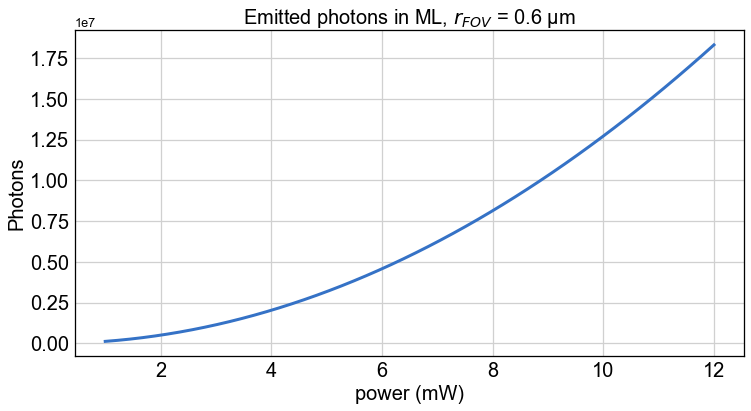

In [131]:
P  = np.linspace(1,12) 
LB2 = [Laser(lamda=650*nm, power=p*mW) for p in P ]
NA  = [emitted_photons_cw_2p(lb, mc) for lb in LB2]

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.plot(P, NA, linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("Photons")
plt.title("Emitted photons in ML, $r_{FOV}$ = 0.6 µm", fontsize=20)
plt.grid(True)

### Detected photons

In [82]:
mcv = Microscope(name='Vacuum', numerical_aperture=0.6, magnification=100,  
                eff_PMT = 1, eff_dichroic = 0.95, eff_filter = 0.99) 
print(mc)


        name                 = True
        NA                   = 6.0e-01
        M                    = 1.0e+02
        eff dichroic         = 9.50e-01
        eff filter           = 9.90e-01
        eff PMT              = 1.00e+00
        Optical transmission = 8.73e-02
        Filter  transmission = 9.41e-01
        Total transmission   = 7.72e-02
        


In [127]:
mc = Microscope(name='Topatu', numerical_aperture=0.6, magnification=100,  
                eff_PMT = 1, eff_dichroic = 0.95, eff_filter = 0.99) 
print(mc)


        name                 = Topatu
        NA                   = 6.0e-01
        M                    = 1.0e+02
        eff dichroic         = 9.50e-01
        eff filter           = 9.90e-01
        eff PMT              = 1.00e+00
        Optical transmission = 8.73e-02
        Filter  transmission = 9.41e-01
        Total transmission   = 7.72e-02
        


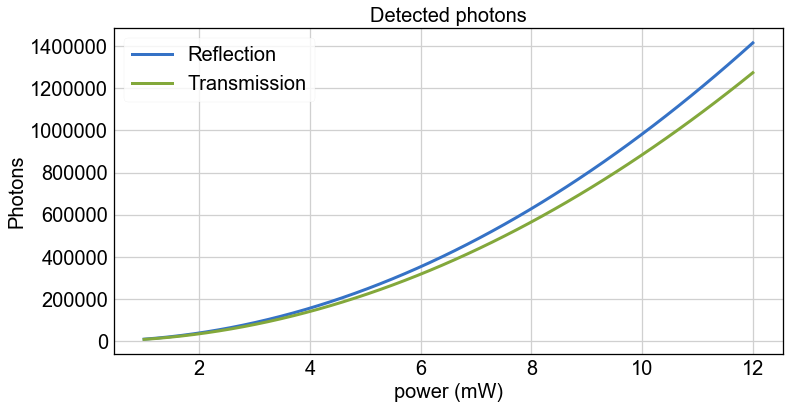

In [147]:
P  = np.linspace(1,12) 
e_quartz = 0.9
LB2 = [Laser(lamda=650*nm, power=p*mW) for p in P ]
NA  = [emitted_photons_cw_2p(lb, mc)*mc.transmission() for lb in LB2]

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.plot(P, NA, linewidth=3, label='Reflection')
plt.plot(P, np.array(NA) * e_quartz , linewidth=3, label='Transmission')

plt.xlabel(r"power (mW)")
plt.ylabel("Photons")
plt.title("Detected photons", fontsize=20)
plt.legend(fontsize=20)

plt.grid(True)

# Calculations for 800 nm pulsed laser, for comparison

In [92]:
lb800 = PulsedLaser(lamda=800*nm, power=1e+2*mW, f=100*MHZ, tau=100*femtosecond)  
lb800


        Pulsed Laser:
        wavelength                =8.0e+02 nm
        photon energy             =1.6e+00 eV
        power                     =1.0e+02 mW
        repetition rate           =1.0e+02 kHz
        pulse width               =1.0e+02 fs
        energy per pulse          =1.0e+04 fJ
        energy per second         =1.0e+02 mJ
        photons per second        =4.0e+17 ph/second
        

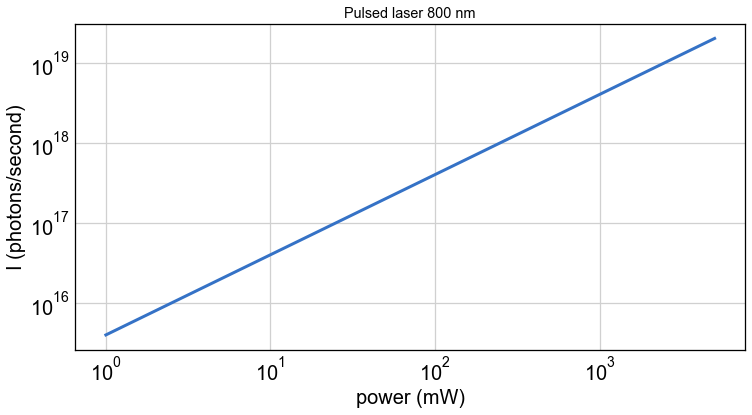

In [148]:
P  = np.linspace(1,5001) 
LB2 =[PulsedLaser(lamda=800*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
FF2 =np.array([lb.n_photons() for lb in LB2])

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.loglog(P, FF2/us, linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("I (photons/second)")
plt.title('Pulsed laser 800 nm')
plt.grid(True)

In [149]:
dl800, f800, i800 = system_photon_density(lb800, mc)
print(f' diffraction limit for 800 nm mc = {dl800/micron}')
print(f' photon density = {i800/(us*ucm2):5.1e} photons/(second cm2)')
print(f' photon density per pulse= {i800/lb800.tau/(us*ucm2):5.1e} photons/(pulse cm2)')

 diffraction limit for 800 nm mc = 0.8133333333333336
 photon density = 7.8e+25 photons/(second cm2)
 photon density per pulse= 7.8e+29 photons/(pulse cm2)


In [97]:
rw = 100 * micron
wfovb= CircularFoV(d = rw, z= 2 * dl800)
wfovb


        FOV; d = 1.0e-01 mm; r = 5.0e-02 mm; z = 1.6e-03 mm;
        area = 7.9e-03 mm2 volume = 1.3e-05 mm3
        

In [99]:
wIb = photon_density(lb800, wfovb)
print(f'photon density = {wIb/(us*ucm2):5.1e} photons/(second cm2)')

print(f'photon density per pulse= {wIb/lb800.tau/(us*ucm2):5.1e} photons/(second cm2)')

photon density = 5.1e+21 photons/(second cm2)
photon density per pulse= 5.1e+25 photons/(second cm2)


## Number of absorbed photons, per fluorophere per pulse (pulsed laser)

http://www.aomf.ca/pdfs/Denk1990.pdf

- equation 9 (in references)

$$ na = \frac{P^2 Q \sigma_2}{\tau f} (\frac{A^2}{2 \hbar c \lambda})^2$$ (8)

where:
- Q is the quantum efficiency (0.9 for fluorescein)
- $\sigma_2$ is the two photon absorption cross section (in cm$^4$ s)
- A is the numerical aperture
- f is the frequency (e.g, 80 MHZ)
- $\tau$ is the FWHM of the pulse width (e.g, 400 fs)
- P is the laser power
- $\lambda$ is the wavelength of the light

- units are photons/fluorophene


In [98]:
rw = 100 * micron
wfov= CircularFoV(d = rw, z= 2 * dl650)
wfov


        FOV; d = 1.0e-01 mm; r = 5.0e-02 mm; z = 1.3e-03 mm;
        area = 7.9e-03 mm2 volume = 1.0e-05 mm3
        

In [100]:
wI = photon_density(lb650, wfov)
print(f'photon density = {wI/(us*ucm2):5.1e} photons/(second cm2)')


photon density = 8.3e+21 photons/(second cm2)


In [75]:
# redefine function in sbt_core to wire FBI by hand and also 
# add dependence with focus. Formula above is in the difractive limit. When wide field is use, na 
# should decrease as (dl / wl)**2

def absorbed_photons_per_fluorophore_per_pulse_2p(lb: GLaser, mc : Microscope)->float:
    """
        na = (p0^2 * delta)/(tau * f^2) * (A^2/(2 hbarc * lambda))^2
        natural units, hbarc = 1
        

    """

    hbarc   = 3.16    * 1e-24                    # J cm
    p0      = lb.power/W                         # W (J/S)
    delta   = sigmaFBI/(cm2*cm2*s)     # cm4 s
    tau     = lb.tau/second                     # s
    f       = lb.f/hertz                            # hZ
    lamda   = lb.lamda/cm                       # cm
    A       = mc.numerical_aperture

    t1 = (p0**2 * qFBI * delta) / (tau * f**2)
    t2 = (A**2 / (2 * hbarc * lamda))**2
    return t1 * t2 

def absorbed_photons_per_fluorophore_per_pulse_2p_wf(lb: GLaser, mc : Microscope, wr : float)->float:
    """
        na = (p0^2 * delta)/(tau * f^2) * (A^2/(2 hbarc * lambda))^2
        natural units, hbarc = 1
        
        wr: radius of wide field

    """

    hbarc   = 3.16    * 1e-24                    # J cm
    p0      = lb.power/W                         # W (J/S)
    delta   = sigmaFBI/(cm2*cm2*s)     # cm4 s
    tau     = lb.tau/second                     # s
    f       = lb.f/hertz                            # hZ
    lamda   = lb.lamda/cm                       # cm
    A       = mc.numerical_aperture

    t1 = (p0**2 * qFBI * delta) / (tau * f**2)
    t2 = (A**2 / (2 * hbarc * lamda))**2
    rd = diffraction_limit(lb, mc)
    #print(f' diffraction limit for laser = {rd/micron}')
    f = (wr / rd)**2
    #print(f' cost factor for WF = {f:5.2e}')
    return t1 * t2 /f

In [101]:
na = absorbed_photons_per_fluorophore_per_pulse_2p(lb800, mc)
na

9.791198484471483

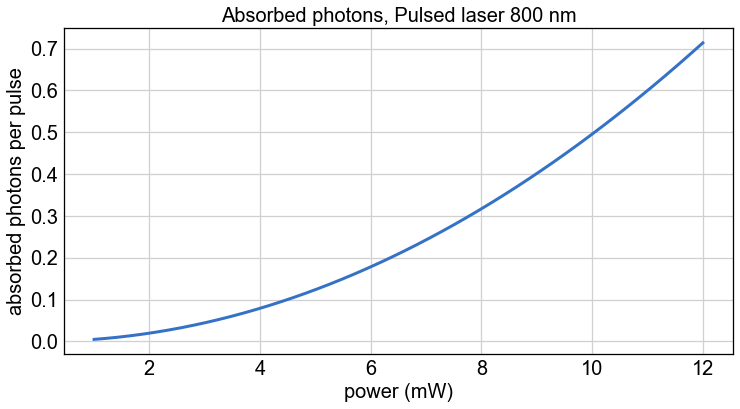

In [106]:
P  = np.linspace(1,12) 
LB2 = [PulsedLaser(lamda=800*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
NA  = [absorbed_photons_per_fluorophore_per_pulse_2p(lb, mcb) for lb in LB2]

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.plot(P, NA, linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("absorbed photons per pulse")
plt.title("Absorbed photons, Pulsed laser 800 nm", fontsize=20)

plt.grid(True)

In [35]:
lb800P = PulsedLaser(lamda=800*nm, power=2.1*W, f=100*MHZ, tau=100*femtosecond) 
nzwf = absorbed_photons_per_fluorophore_per_pulse_2p_wf(lb800P, mc, wr=100*micron)
nzwf

2.0605353495834002

### Thus the laser just saturates the molecule in each pulse. The number of emitted photons is simply the number of pulses

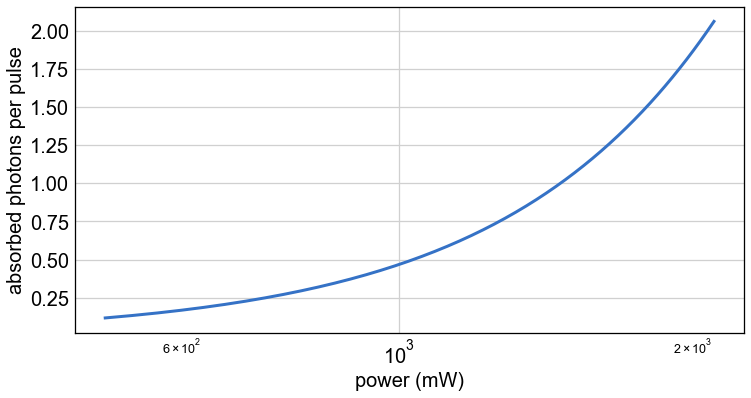

In [36]:
P  = np.linspace(501,2101) 
LB2 = [PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond) for p in P ]
NA  = [absorbed_photons_per_fluorophore_per_pulse_2p_wf(lb, mc, wr=100*micron) for lb in LB2]

fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
    
plt.semilogx(P, NA, linewidth=3)
plt.xlabel(r"power (mW)")
plt.ylabel("absorbed photons per pulse")
plt.grid(True)

In [36]:
def snr(nf, epsilon_f, epsilon_a, F, m):
    f = nf * epsilon_f * epsilon_a * F / m
    return f, np.sqrt(f)

In [37]:
f, sNr = snr(1e+8, 0.29, 0.1, 2.5e+4, 1)
print(f'f = {f:.2e}; SNR = {sNr:.2e}')

f = 7.25e+10; SNR = 2.69e+05


In [38]:
def nof_m(rho, df):
    r = df/2
    return rho * (np.pi * r**2)

In [39]:
m = nof_m(rho=1e+6, df=0.5)
print(f'm = {m:.2e}')

m = 1.96e+05


In [40]:
f, sNr = snr(1e+8, 0.29, 0.1, 2.5e+4, m)
print(f'f = {f:.2e}; SNR = {sNr:.2e}')

f = 3.69e+05; SNR = 6.08e+02


In [41]:
def diff_spot_scanning_time(nf, epsilon_f, epsilon_a, F, m, SNR=10):
    _, sNr = snr(nf, epsilon_f, epsilon_a, F, m)
    return (SNR/sNr)**2 * second
    

In [42]:
t = diff_spot_scanning_time(1e+8, 0.29, 0.1, 2.5e+4, m, SNR=20)
print(f'scanning time = {t/ms} ms')

scanning time = 1.083307811582687 ms


In [43]:
def scanning_time(dfov, speed, area):
    r = dfov / 2
    a = np.pi * r**2
    print(a/cm2)
    return speed * area/(a)

In [44]:
st = scanning_time(dfov = 100 * micron, speed = 1e-3, area= 1 * cm2)
print(f' scanning time = {st:.2f} / second')

7.853981633974484e-05
 scanning time = 12.73 / second


In [52]:
2.7 / 2

1.35

In [68]:
2.5E4**2/1e+8

6.25

In [46]:
n_f = n_pulses_per_second = lb2.f/hertz
print(f' number of produced photons per fluorophore per second = {n_pulses_per_second:5.1e}')

 number of produced photons per fluorophore per second = 1.0e+08


## Monolayer

## Signal to noise

- Consider a monolayer spot iluminated by the laser. The spot contains $m$ molecules, of which one molecule is chelated. 
- The number of photons emited by the chelated molecule as a response to the laser pulse will be distributed around $n_p$, where $n_p$ is computed from $n_a$ (equation 8), $n_f = n_a/2)$. Notice that if $n_a$ is larger than 2 (the number of photons that the molecule can absorbe per pulse) then $n_p = 1$. 
- The fluorescence emitted in a given time interval by the chelated molecules will be $n_f$. In a second, with a 100 MHz laser and in the absence of photobleaching, $n_f = 10^8$. 
- The remaining molecules ($m -1 \sim m$, since $m$ is large) will emit (per molecule, in average) $n_f/\alpha$, where $\alpha$ is the ratio of fluorescence between chelated and unchelated molecules (e.g, $\alpha  \sim 100$ for FIB). The total fluorescence emitted by the background molecules will therefore be distributed around $n_b = \frac{n_f \,m}{\alpha}$.
- The signal to noise ration (SNR) is simply:

$$SNR = \frac{n_f}{\sqrt{n_b}} = \frac{n_f}{\sqrt{\frac{n_f \, m}{\alpha}}} = \sqrt{\frac{n_f\, \alpha}{m}} $$

In terms of the number of detected photons we need to multiply by the detection efficiency $\epsilon$. 

$$SNR =  \sqrt{\epsilon \frac{n_f\, \alpha}{m}} $$

### The number of photons per fluorophere per second should then simply be equal to the number of pulses, sice we saturate

In [80]:
n_f = n_pulses_per_second = lb.f/hertz
print(f' number of produced photons per fluorophore per second = {n_pulses_per_second:5.1e}')

 number of produced photons per fluorophore per second = 7.6e+07


#### alpha is the molecule signal to noise ratio

In [81]:
alpha = 1E+4

### Assuming detection efficiency = 1

In [82]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = n_f, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 7.6e+07
        n_b               = 7.6e+03
        alpha (snr c/u)   = 1.0e+04
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 7.6e+09
        snr               = 8.7e+02
        

### Taking into account the detection efficiency and the camera speed (100 frames per second, thus 10 ms)

In [65]:
mc.transmission()

0.081450625

In [84]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = n_f * mc.transmission()/100, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 2.1e+05
        n_b               = 2.1e+01
        alpha (snr c/u)   = 1.0e+04
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 2.1e+07
        snr               = 4.6e+01
        

In [86]:
ml.snr

45.998427894385685

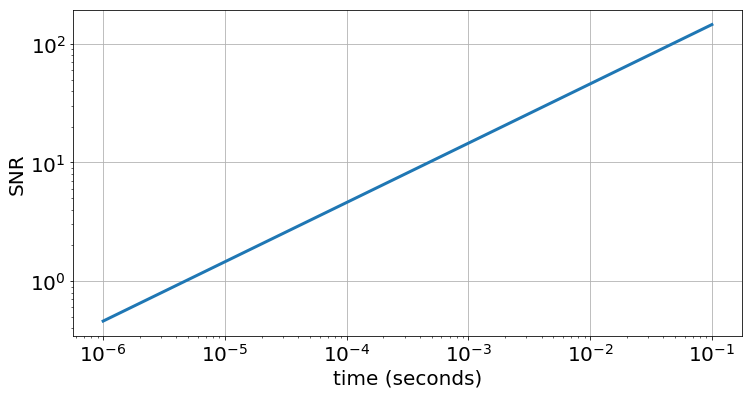

In [90]:
T = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
NF = [n_f * mc.transmission() * t for t in T]
ML = [Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nf, alpha=alpha) for nf in NF]
SNR =[ml.snr for ml in ML]
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

set_fonts(ax, fontsize=20)
plt.loglog(T, SNR, linewidth=3)
plt.xlabel('time (seconds)')
plt.ylabel('SNR')
plt.grid()

In [92]:
np.sqrt(0.2 * 1e+8 * 1.2e+4 /1e+6)

489.89794855663564

### Statistical test

run 1000 experiments in 26.131208896636963 seconds


(array([  9.,  16.,  70., 148., 229., 235., 174.,  83.,  26.,  10.]),
 array([175609.82005923, 178303.03225025, 180996.24444128, 183689.4566323 ,
        186382.66882332, 189075.88101434, 191769.09320537, 194462.30539639,
        197155.51758741, 199848.72977843, 202541.94196945]),
 <a list of 10 Patch objects>)

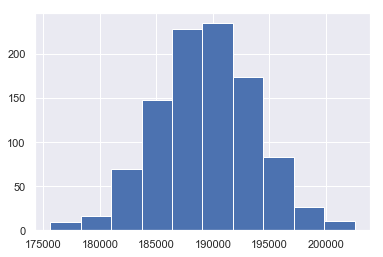

In [45]:
n  = int(1e+3)
t0 = time.time()
N = [ml.nsignal() for i in range(n)]
t1 = time.time()
print(f'run {n} experiments in {t1-t0} seconds')
plt.hist(N, bins=10)

In [46]:
np.average(N) / np.std(N)

43.67320515188006

In [42]:
n  = int(1e+3)
t0 = time.time()
N  = signal(ml, n_exp = n)
t1 = time.time()
print(f'run {n} experiments in {t1-t0} seconds')

run 1000 experiments in 25.00779700279236 seconds


(array([  5.,  19.,  46., 129., 241., 245., 185.,  96.,  30.,   4.]),
 array([0.90209252, 0.9207116 , 0.93933067, 0.95794975, 0.97656882,
        0.9951879 , 1.01380698, 1.03242605, 1.05104513, 1.0696642 ,
        1.08828328]),
 <a list of 10 Patch objects>)

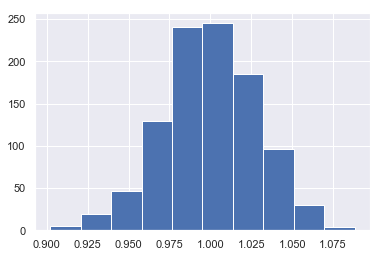

In [43]:
plt.hist(N, bins=10)

In [44]:
np.average(N) / np.std(N)

34.8021511643825

### alpha = 10

In [56]:
alpha = 5

In [57]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = n_f * mc.transmission(), alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 1.9e+07
        n_b               = 3.8e+06
        alpha (snr c/u)   = 5.0e+00
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 3.8e+12
        snr               = 9.7e+00
        

In [72]:
def na_chelated(rate = 1e+8, frame=1e-2, epsilon = 0.2):
    return rate * frame * epsilon

In [77]:
na_chelated(rate = 1e+8, frame=1e-2, epsilon = 0.2)

200000.0

In [75]:
F= 1.2e+4

In [76]:
na_chelated(rate = 1e+8, frame=1e-2, epsilon = 0.2) / F

16.666666666666668

#### Thus one could get to 10 ms steps with a 100 MHz beam and in the absence of photobleaching. Ways to improve:
- Use a GHz laser (feasible).
- Use plasmonic amplification. 

#### Photobleaching
- Photobleaching (PB) will burn the molecule if it emits more than a given number of photons. 
- It appears that with 10^5 photons is possible to identify the molecule. Thus if PB is below that range, we are OK. 
- Notice that all molecules emit, so if PB occurs at low values of light emmission the scan would burn the target.
- PB for fluorescein occurs at 360,000 photons in deoxygenated environment.
- The FIB molecule will work in dry medium, with very small amounts of oxygen. The feasibility of the experiment depends of a PB level being sufficiently low, but that appears reasonable given the PB level of Fluorescein. 
- Alternatively plasmonic amplification could amplify the signal and avoid reaching PB criticality.

## Scanning time

- In a monolayer molecules will be packed at 1 nm separation. The ML itself will be 1 nm thick.
- Assume that the beam will illuminate a region of 1 mu2. 
- Then, if the mirror speed can be tuned to 1 khz, one could cover 1E+3 points per second. 
- Assuming that 1 ms exposure is enough, one can use an array of beams to cover the transverse coordinate.
- Using 20 beams, one needs 50 seconds to cover the 1 mm2 sample, which appears reasonable!
- If each point takes longer (e.g, above, 10 ms), one could still be OK (500 s scan is less than 10 minutes). 